##  Propensity Scoring 

In this section we will do propenisty score matching that we can exclude the influence of covariates. The "treatment" in this case will be if the people eat healty or not. To classify if the average product is healty we relay on the recommandations of th WHO. From these recommandations a binary variable is created. How this is done will be explained later. The covariates are different demographical measures like:
- mean age
- population density
- total population
- Multiple deprivation index
- total people in different age groups

Base on these covariates a logistic model is fit to predict the probabilty of an area to be classified as healthy or not. This is the propensity score. Base on this score areas with a close score are matched together.

### Relevancy of the dataset

Even though that the dataset from tesco is from 2015 we belive that its still relevant for the investigation of the influence of nutrition on covid deaths. Because nutrititonal habits only change very slowly and because the effects of bad nutrition have long lasting effects. For example disieses like diabetes and Adipositas


In [1]:
#importing all relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pymatch.Matcher import Matcher
import statistics
"""
There was an error in the pymatcher package so the following has to be changed in the mathcer function on th e bottom 

def _scores_to_accuracy(m, X, y):
    preds = [1.0 if i >= .5 else 0.0 for i in m.predict(X)]
    return (y == preds).sum() * 1.0 / len(y)

def _scores_to_accuracy(m, X, y):
    preds = [1.0 if i >= .5 else 0.0 for i in m.predict(X)]
    # return (y == preds).sum() * 1.0 / len(y)
    return (y.to_numpy().T == preds).sum() * 1.0 / len(y)

"""
%matplotlib inline

In [2]:
#loading the data from csv files
food = pd.read_csv("Data/year_msoa_grocery.csv")
deaths = pd.read_csv("Data/coviddeaths.csv")
imd = pd.read_csv("Data/imd2019_msoa_level_data.csv")
#Mergin all the data
merged = imd.merge(deaths, left_on="MSOAC", right_on="MSOA code").drop("MSOA code",axis=1)
df = merged.merge(food, left_on="MSOAC", right_on="area_id").drop(["March","April","May","June","July","LSOACOUNT","POPMID15"], axis=1)
df.rename(columns={'IMD19 SCORE':'IMD19_SCORE'}, inplace=True)
df.rename(columns={'Covid Deaths March to July':'Covid_deaths_march_july'}, inplace=True)
df.rename(columns={'age_65+':'age_65'}, inplace=True)
df.head()

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,man_day,population,male,female,age_0_17,age_18_64,age_65,avg_age,area_sq_km,people_per_sq_km
0,E02000001,14.720484,4,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,...,103934,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069
1,E02000002,34.767560,8,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,...,9952,7379.0,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704
2,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,19576,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794
3,E02000004,23.560044,14,E02000004,347.481292,29.0,126.0,250.0,430.0,1000.0,...,10689,6536.0,3119.0,3417.0,1454.0,4044.0,1038.0,38.493115,2.48,2635.483871
4,E02000005,30.212965,7,E02000005,400.576688,32.5,150.0,296.0,500.0,1050.0,...,15071,9243.0,4478.0,4765.0,2678.0,5554.0,1011.0,34.156335,1.19,7767.226891


### 1. Data prepartion

To ensure that we only take areas that are well represented by the Tesco data set. We consider only areas with a representativeness norm bigger than 0.16. This leaves us with about 77% of all areas

In [3]:
df_rep = (df[df["representativeness_norm"]>0.16]).reset_index(drop=True)
len(df_rep)/len(df)
df_rep

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,man_day,population,male,female,age_0_17,age_18_64,age_65,avg_age,area_sq_km,people_per_sq_km
0,E02000001,14.720484,4,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,...,103934,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069
1,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,19576,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794
2,E02000009,36.336546,7,E02000009,403.380279,32.5,160.0,300.0,500.0,1200.0,...,25814,10504.0,5095.0,5409.0,3192.0,6498.0,814.0,31.686215,0.96,10941.666667
3,E02000011,25.713969,12,E02000011,364.818183,28.5,142.0,250.0,450.0,1000.0,...,10824,6761.0,3318.0,3443.0,1774.0,4069.0,918.0,36.312380,1.60,4225.625000
4,E02000012,20.632166,8,E02000012,428.223742,37.0,170.0,300.0,500.0,1500.0,...,34091,10858.0,5377.0,5481.0,2906.0,6770.0,1182.0,34.166421,1.29,8417.054264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,E02006927,22.646314,10,E02006927,382.625053,34.0,160.0,300.0,500.0,1000.0,...,45833,9450.0,4455.0,4995.0,2282.0,5700.0,1468.0,37.527090,2.52,3750.000000
754,E02006928,20.761873,2,E02006928,372.224870,35.0,160.0,300.0,500.0,1000.0,...,81761,10126.0,4968.0,5158.0,2014.0,7735.0,377.0,29.600632,0.55,18410.909091
755,E02006929,27.115006,7,E02006929,348.194548,32.5,150.0,270.0,450.0,1000.0,...,50516,8464.0,4168.0,4296.0,1658.0,6109.0,697.0,33.643904,2.55,3319.215686
756,E02006930,20.582796,4,E02006930,347.600391,34.0,150.0,270.0,450.0,1000.0,...,39886,7537.0,3789.0,3748.0,1472.0,5436.0,629.0,33.773650,0.88,8564.772727


### 2. Creating the binary variable based on nutrition

Base on the recomondations from the WHO we will create a binary variable if the nutrition in the area is close to the recomondations. 

The following recomondations have been taken from this website https://www.who.int/publications/m/item/healthy-diet-factsheet394. 

"Less than 10% of total energy intake from free sugars (2, 7), which is equivalent to 50 g (or about 12 level teaspoons) for a person of healthy body weight consuming about 2000 calories per day, but ideally is less than
5% of total energy intake for additional health benefits (7). Free sugars are all sugars added to foods or drinks
by the manufacturer, cook or consumer, as well as sugars naturally present in honey, syrups, fruit juices and
fruit juice concentrates

Less than 30% of total energy intake from fats (1, 2, 3). Unsaturated fats (found in fish, avocado and nuts, and
in sunflower, soybean, canola and olive oils) are preferable to saturated fats (found in fatty meat, butter, palm
and coconut oil, cream, cheese, ghee and lard) and trans-fats of all kinds, including both industrially-produced
trans-fats (found in baked and fried foods, and pre-packaged snacks and foods, such as frozen pizza, pies,
cookies, biscuits, wafers, and cooking oils and spreads) and ruminant trans-fats (found in meat and dairy foods
from ruminant animals, such as cows, sheep, goats and camels). It is suggested that the intake of saturated
fats be reduced to less than 10% of total energy intake and trans-fats to less than 1% of total energy intake (5).
In particular, industrially-produced trans-fats are not part of a healthy diet and should be avoided (4, 6)."

Furthermore we will includ the criterion that less alcohol consumption is healthier. 



In [4]:
# creating the columns showing the percentage of the energy coming from nutrition x in relation to the total energy
def ratio(energy_total, energy_nutrient):
    return energy_nutrient/energy_total
df_rep["ratio_fat"] = df_rep.apply(lambda row: ratio(row["energy_tot"],row["energy_fat"]), axis=1)
df_rep["ratio_saturate"] = df_rep.apply(lambda row: ratio(row["energy_tot"],row["energy_saturate"]), axis=1)
df_rep["ratio_sugar"] = df_rep.apply(lambda row: ratio(row["energy_tot"],row["energy_sugar"]), axis=1)
df_rep.head()

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,female,age_0_17,age_18_64,age_65,avg_age,area_sq_km,people_per_sq_km,ratio_fat,ratio_saturate,ratio_sugar
0,E02000001,14.720484,4,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,...,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069,0.459817,0.182428,0.223769
1,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794,0.444657,0.178014,0.260653
2,E02000009,36.336546,7,E02000009,403.380279,32.5,160.0,300.0,500.0,1200.0,...,5409.0,3192.0,6498.0,814.0,31.686215,0.96,10941.666667,0.441808,0.172274,0.224516
3,E02000011,25.713969,12,E02000011,364.818183,28.5,142.0,250.0,450.0,1000.0,...,3443.0,1774.0,4069.0,918.0,36.312380,1.60,4225.625000,0.453379,0.174168,0.248639
4,E02000012,20.632166,8,E02000012,428.223742,37.0,170.0,300.0,500.0,1500.0,...,5481.0,2906.0,6770.0,1182.0,34.166421,1.29,8417.054264,0.448406,0.179272,0.240974


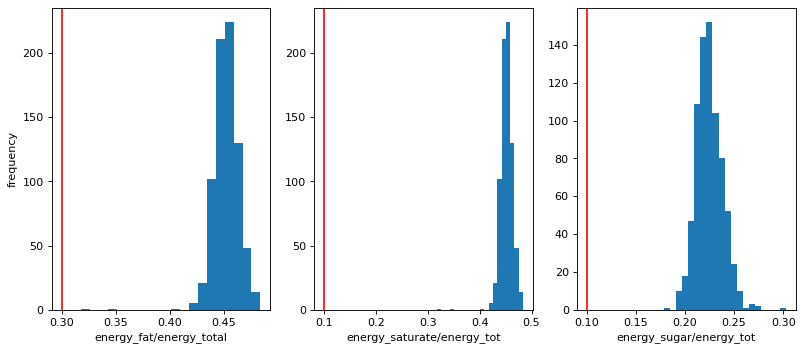

In [5]:
plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.hist(df_rep["ratio_fat"], bins=20)
plt.xlabel("energy_fat/energy_total")
plt.ylabel("frequency")
plt.axvline(0.30,c="r")

plt.subplot(132)
plt.hist(df_rep["ratio_fat"], bins=20)
plt.xlabel("energy_saturate/energy_tot")
plt.axvline(0.10,c="r")

plt.subplot(133)
plt.hist(df_rep["ratio_sugar"], bins=20)
plt.xlabel("energy_sugar/energy_tot")
plt.axvline(0.10,c="r");

As we can see from the plots above non of the areas satisfy the recommandations by the WHO. Therefore we classify 50% of the areas which are closest to the recommandations as healthy. This will be done by k nearest neighbors. For this the ratios will be converted to a distance measure, ratio observed - recommandation value = distance from recommandation. Then we can take the 50% which are closest to 0 in the 4 features :distance_fat, distance_sugar, distance_saturated, alcohole

In [6]:
#creating the distance measures for the recommandations
def distance(nutrient,rec):
    return nutrient-rec
features = pd.DataFrame(columns=["distance_fat","distance_saturate","distance_sugar","alcohol"])
features["distance_fat"] = df_rep.apply(lambda row: distance(row["ratio_fat"],0.30), axis=1)
features["distance_saturate"] = df_rep.apply(lambda row: distance(row["ratio_saturate"],0.10), axis=1)
features["distance_sugar"] = df_rep.apply(lambda row: distance(row["ratio_sugar"],0.5), axis=1)
features["alcohol"] = df_rep["alcohol"]

In [7]:
#finding the nearest neigbors of the point [0,0,0,0]
from sklearn.neighbors import NearestNeighbors
half = int(len(features)/2)
optimum = np.array([0,0,0,0]).reshape(1, -1)
nbrs = NearestNeighbors(n_neighbors=half, algorithm='ball_tree').fit(features)
distances , indices = nbrs.kneighbors(optimum)

#crating healthy binary variabel base on the returned set from kneighbors
nearest_indices = indices.tolist()[0]

def healthy(index):
    return 1 if index in nearest_indices else 0

def rowIndex(row):
    return row.name

df_rep["rowIndex"] = df_rep.apply(lambda row: rowIndex(row), axis=1)
df_rep["healthy"] = df_rep.apply(lambda row: healthy(row["rowIndex"]), axis=1)

### 3. Propensity score matching
For the matching we use the package pymatcher which has the most important functions implemented


In [8]:
#creating the covariates for the propensity matching. These are all the demographic data from the tesco datasat + the imd score
healthy = df_rep[df_rep["healthy"]==1][["representativeness_norm","male","female","population","people_per_sq_km","avg_age","age_0_17","age_18_64","age_65","IMD19_SCORE","healthy"]]
unhealthy = df_rep[df_rep["healthy"]==0][["representativeness_norm","male","female","population","people_per_sq_km","avg_age","age_0_17","age_18_64","age_65","IMD19_SCORE","healthy"]]


Formula:
healthy ~ representativeness_norm+male+female+population+people_per_sq_km+avg_age+age_0_17+age_18_64+age_65+IMD19_SCORE
n majority: 379
n minority: 379
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 76.25%


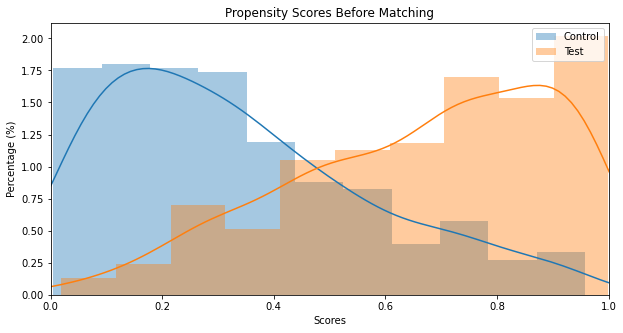

In [9]:
#Initiating the Matcher class Matcher and calculating 100 models log regression models
from pymatch.Matcher import Matcher
m = Matcher(healthy,unhealthy , yvar="healthy", exclude=[])
m.fit_scores(nmodels=100)
m.predict_scores()
m.plot_scores()

We see that the plots show seperability. The propensity scores for the test variable(healty areas) are way higher for the unhealthy areas. This is alsoe shwon with the average accuracy above 50% of 72%

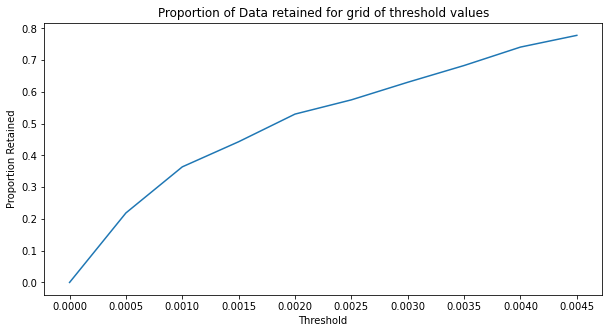

In [10]:
m.tune_threshold(method="random", rng=np.arange(0, .005, .0005))

Since our dataset is be design balance, 50% of the areas are classified as healthy and 50% healthy we need to find a good treshold. Because with a threshold of infity the propensity score would do nothing. So we have to tune it to get the best matching. We found that 0.025 gave the best matching.

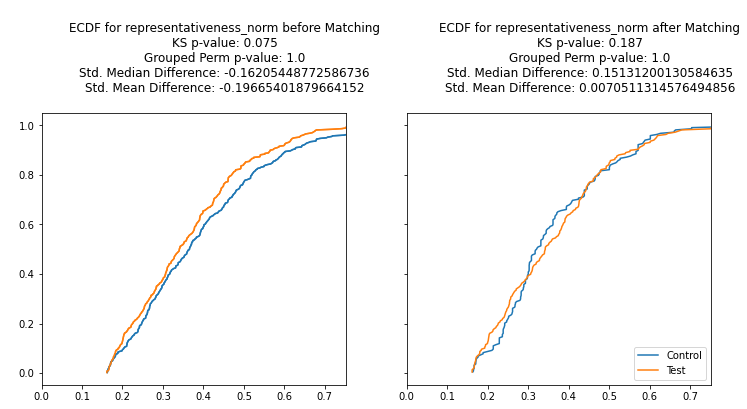

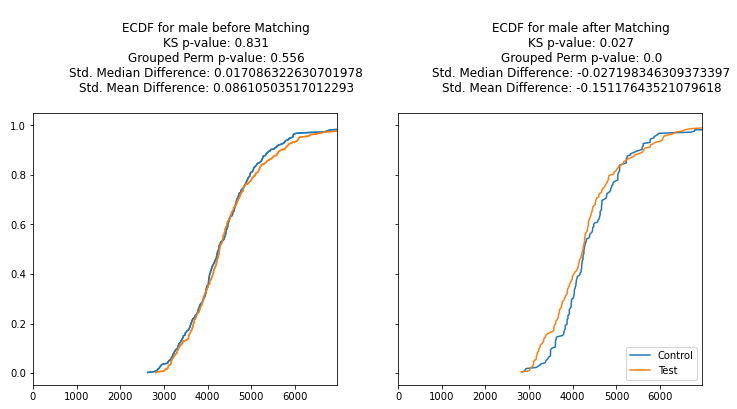

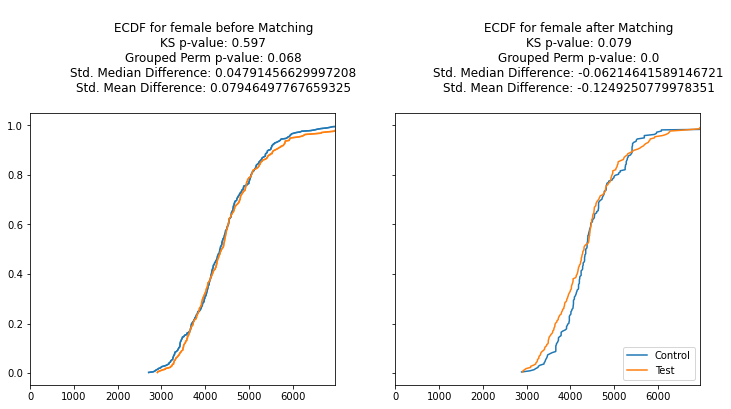

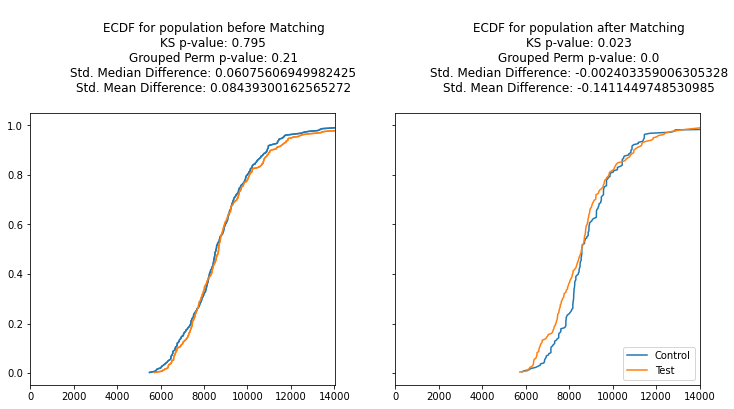

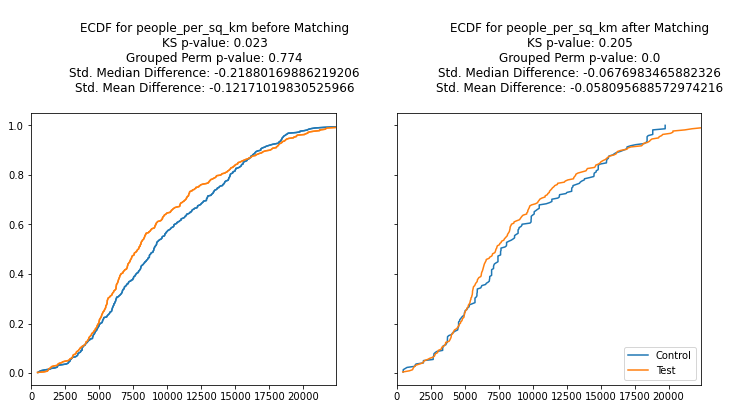

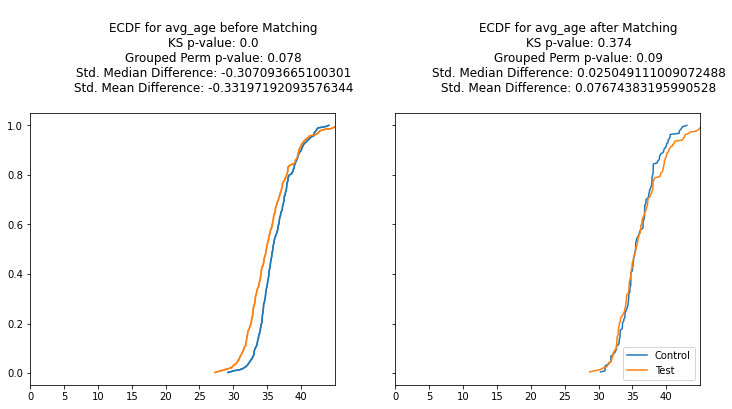

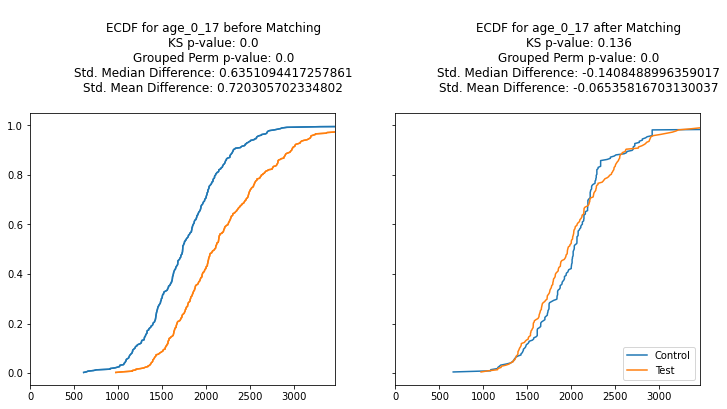

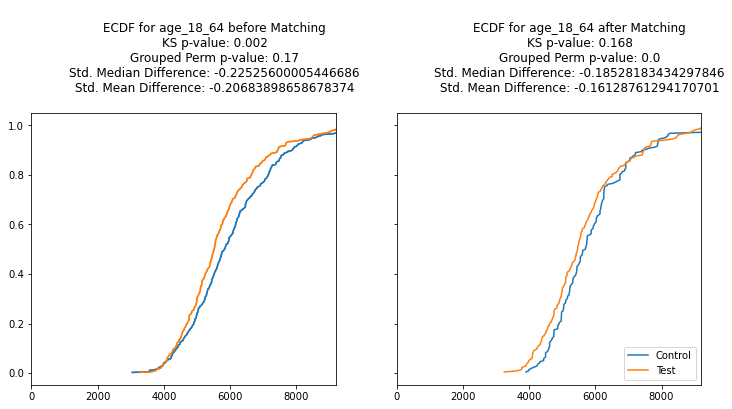

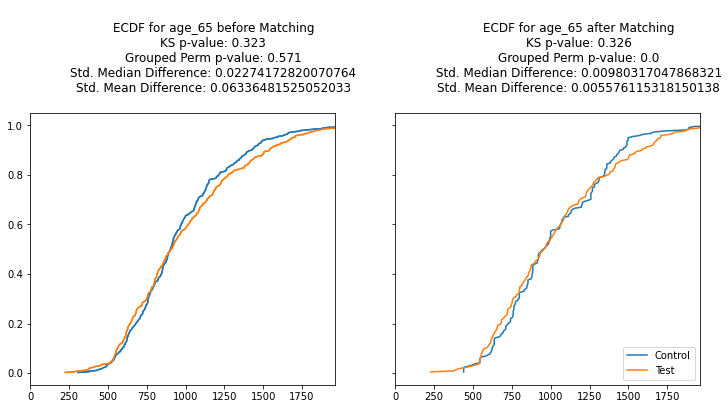

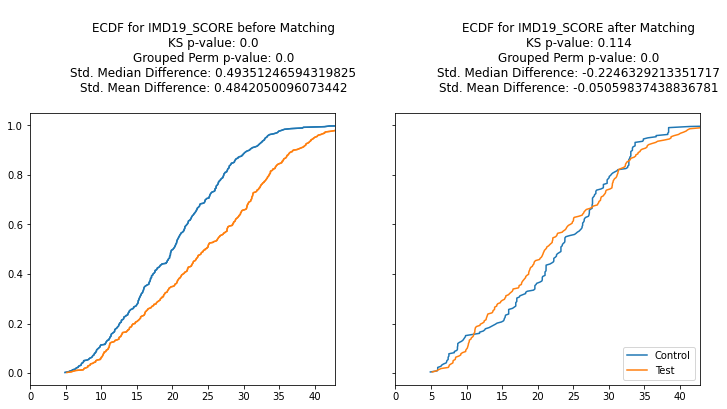

In [11]:
m.match(method="random", nmatches=1, threshold=0.0025) #the random flags means that if many points are in the threshold area a random one is chosen. We found this gives better results. because otherwise one point would be match 30 times because its matching with repetiton in the majority set.
cc = m.compare_continuous(return_table=True)

Now we have to check to see the quality of the matching. For that we use the plots of the estimator of the Cumulative Distribution Function and Kolmogorov-Smirnov Goodness of fit teast and the chi.square distance similarity. But first we focus on the plots. The goal is that both graphs are very close together. We can see that some graphs are alredy very close together before the matching. For example male, femal and population. This is by design of the msoa areas. Therefore we dont have to consider those during matching. We will redo the first steps without these covariates. 

Formula:
healthy ~ representativeness_norm+people_per_sq_km+avg_age+age_0_17+age_18_64+age_65+IMD19_SCORE
n majority: 379
n minority: 379
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 73.22%


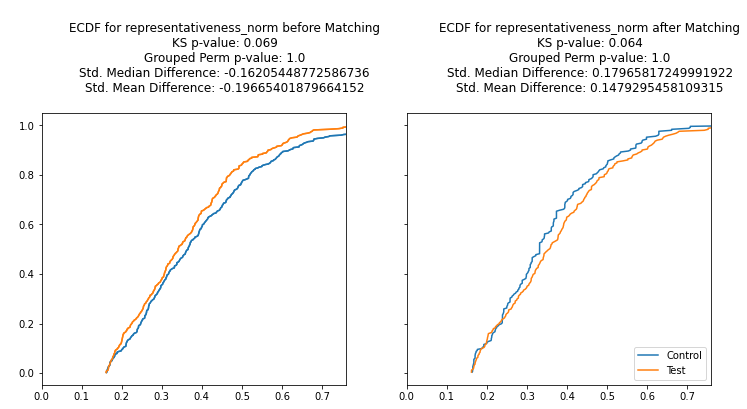

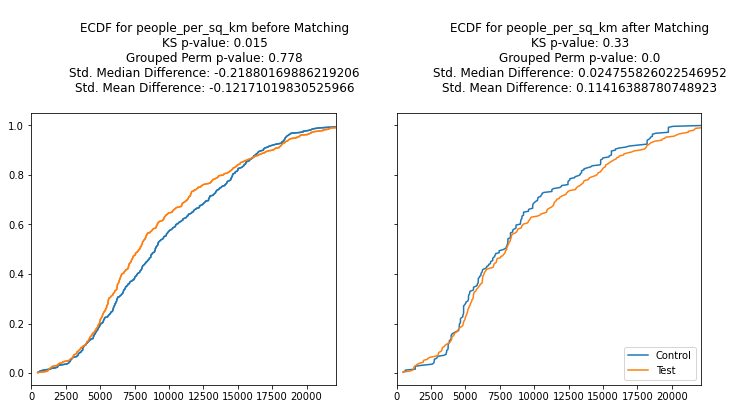

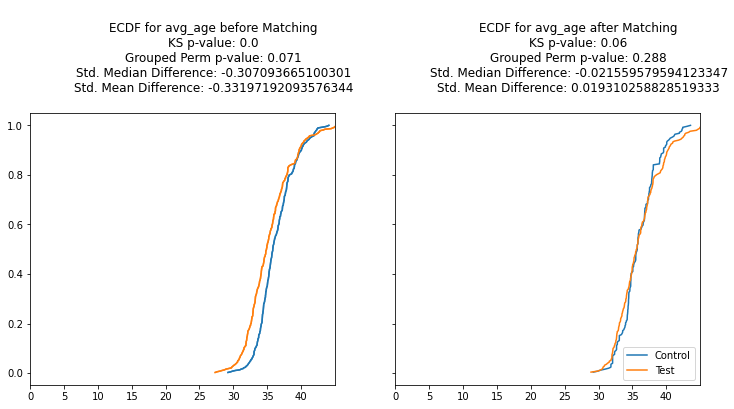

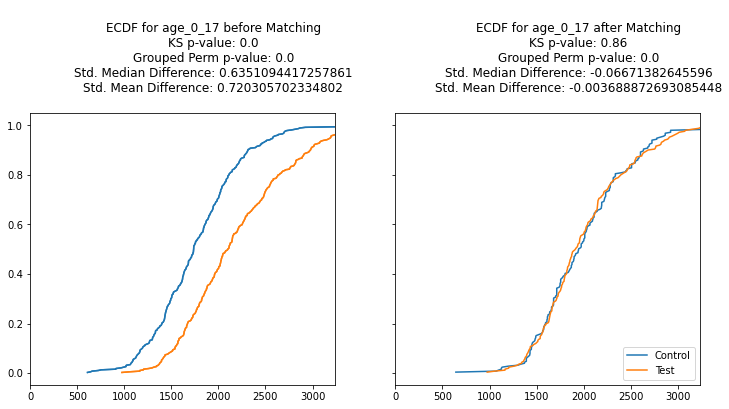

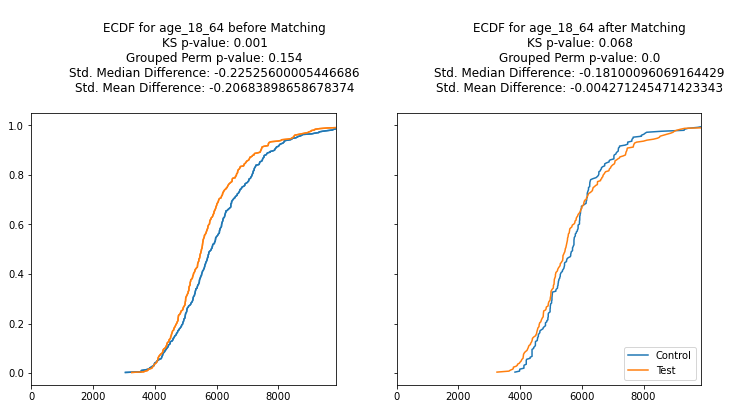

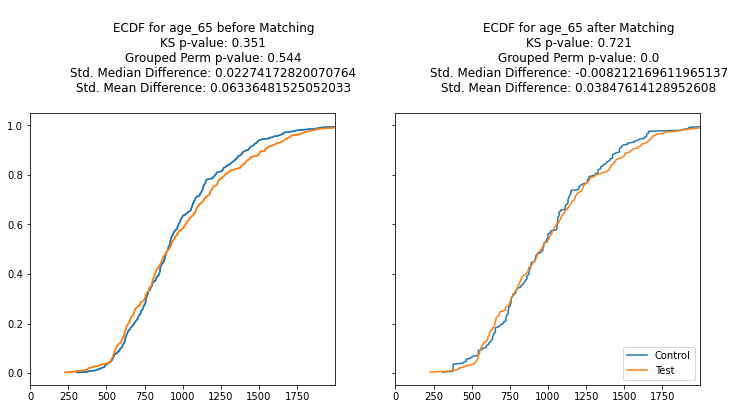

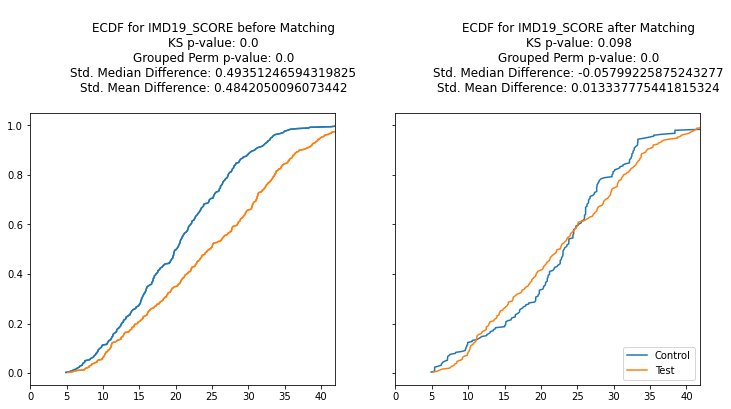

In [12]:
#creating the covariates for the propensity matching. This time without male, femal and population feature
healthy = df_rep[df_rep["healthy"]==1][["representativeness_norm","people_per_sq_km","avg_age","age_0_17","age_18_64","age_65","IMD19_SCORE","healthy"]]
unhealthy = df_rep[df_rep["healthy"]==0][["representativeness_norm","people_per_sq_km","avg_age","age_0_17","age_18_64","age_65","IMD19_SCORE","healthy"]]

#Initiating the Matcher class Matcher and calculating 100 models log regression models
from pymatch.Matcher import Matcher
m = Matcher(healthy,unhealthy , yvar="healthy", exclude=[])
m.fit_scores(nmodels=100)
m.predict_scores()

m.match(method="random", nmatches=1, threshold=0.0025)
cc = m.compare_continuous(return_table=True)

In [13]:
print(((cc["ks_after"]>0.05).sum() - (cc["ks_before"]>0.05).sum()))
print(((cc["grouped_chisqr_after"]>0.05).sum() - (cc["grouped_chisqr_before"]>0.05).sum()))

5
-3


Now looking at the KS-test and the Chi-Square Distances we can compare how many distributions satisfiy the condition to be > 0.05. From the plot above we see that the KS-Test is improved for most of the distributions but the Chi-square distance is decreased for most distributions. We are a bit unsure why we observe this behavior or how to fix it. 

In [14]:
#Creating new dataframe with the matches and the origonal dataframe
df = pd.merge(df_rep,m.matched_data,how="left")
df_matched = (df[df["match_id"].notna()]).sort_values("match_id")
df_matched.head(6)

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,area_sq_km,people_per_sq_km,ratio_fat,ratio_saturate,ratio_sugar,rowIndex,healthy,scores,match_id,record_id
1,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,2.14,5009.345794,0.444657,0.178014,0.260653,1,1,0.882918,0.0,0.0
385,E02000466,23.824340,10,E02000466,316.507137,25.0,120.0,220.0,400.0,1000.0,...,6.28,1364.331210,0.446791,0.178465,0.244397,345,0,0.883279,0.0,537.0
336,E02000415,27.363437,6,E02000415,392.839446,37.0,165.0,300.0,500.0,1000.0,...,0.70,10242.857143,0.454301,0.177861,0.216002,299,0,0.417788,10.0,520.0
22,E02000032,8.446301,6,E02000032,373.395385,32.5,151.0,296.0,500.0,1000.0,...,1.41,5468.794326,0.450067,0.177754,0.228044,20,1,0.416221,10.0,10.0
160,E02000240,29.908371,12,E02000240,379.029016,32.5,150.0,290.0,500.0,1000.0,...,1.72,5939.534884,0.446169,0.178389,0.237011,147,0,0.909789,13.0,436.0
27,E02000037,11.128158,14,E02000037,361.534523,32.5,150.0,280.0,465.0,1000.0,...,4.32,2248.148148,0.445787,0.178857,0.268411,25,1,0.911690,13.0,13.0


## 4. Comparing covid deaths for healthy/unhealthy MSOA's

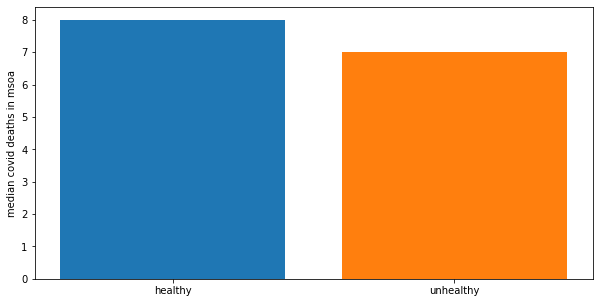

In [15]:
#creating plots of the median deaths in healthy areas vs unhealthy areas
fig, ax = plt.subplots()
healthy = statistics.median(df_matched[df_matched["healthy"]==1]["Covid_deaths_march_july"])
unhealthy = statistics.median(df_matched[df_matched["healthy"]==0]["Covid_deaths_march_july"])
ax = plt.bar("healthy",healthy)
ax = plt.bar("unhealthy",unhealthy)
plt.ylabel("median covid deaths in msoa");

We observe, that areas which eat less healthy according the who guidlines actually are less likely to die of corona. We can quantify this with the average treatment effect. 

In [16]:
ATE = 0
for match in list(df_matched["match_id"].unique()) :
    pair = df_matched[df_matched["match_id"]==match]
    healthy = pair[pair["healthy"]==1]
    unhealthy = pair[pair["healthy"]==0]

    ATE += healthy["Covid_deaths_march_july"].values[0]-unhealthy["Covid_deaths_march_july"].values[0]
print("The average treatment effect ist: {}".format(ATE))

The average treatment effect ist: 295


So fare whe have no explenation what the reason could be for this result it would be more intiutive that healthy areas have less covid deaths than unhealthy. On reason could be that the tesco dataset is not as relevant as we claimed it to be. A reason for that could be that many people have moved or the nutritional behavior have drastically changed. Another option would be to implement this method from K. Imai, M. Ratkovic. Which could lead to a better matching https://rss.onlinelibrary.wiley.com/doi/10.1111/rssb.12027

In [17]:
#Import list
import scipy
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from statsmodels.discrete.discrete_model import Logit, MNLogit
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

In [129]:
#Use of scikit library for boosted decision trees
#Builld gradient boosted decision regressor
#Add crosss validation to find hyperparameters.
def BoostedTree(X, y, train, test):
    model = GradientBoostingRegressor(learning_rate= .1, n_estimators = 100, max_depth = 3)
    model.fit(train[X], train[y])
    y_pred = model.predict(test[X])
    r2 = r2_score(test[y], y_pred)
    return model, r2

#Operates cross-validation for specified N-Fold and hyperparameters
def CrossVal(X, y, train, N=20, n_estimators=100, learning_rate=0.1, max_depth=3):
    model = GradientBoostingRegressor(learning_rate= learning_rate, n_estimators = n_estimators, max_depth = max_depth)
    r2s = cross_validate(model, train[X], train[y], scoring='r2', cv=N)['test_score']
    return np.asarray(r2s).mean()

#Function that finds the best set of parameters among the given lists based on a training set
#estimators : list of int, estimator
#learnings : list of learning rates
#depths : list of maximum depths of the tree
def FindHParams (X, y, train, estimators, learnings, depths, N=20):
    best_estimator = estimators[0]
    best_learning = learnings[0]
    best_depth = depths[0]
    best_r2mean = -1
    
    for estimator in estimators:
        for learning in learnings:
            for depth in depths:
                r2mean = CrossVal(X, y, train, N, estimator, learning, depth)
                
                if r2mean>best_r2mean:
                    best_r2mean = r2mean
                    best_estimator = estimator
                    best_learning = learning
                    best_depth = depth
    return best_estimator, best_learning, best_depth

## 5. Study variable dependence excluding healthy/unhealthy

Next we will try to build different regression models to determine which covariate has the most impact on Covid-19 deaths.
To do so, we will first study covariates excluding the newly calculated features healthy/unhealthy. We will stick with the possible independent variables from the paper. 

In [148]:
#Define dependent variables
X = ["IMD19_SCORE", "weight", "volume", "energy_density", "representativeness_norm", "people_per_sq_km","age_0_17"
     ,"age_18_64","age_65"]
#Independent variable
y = ["Covid_deaths_march_july"]

In [132]:
df_rep.head()

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,age_18_64,age_65,avg_age,area_sq_km,people_per_sq_km,ratio_fat,ratio_saturate,ratio_sugar,rowIndex,healthy
0,E02000001,14.720484,4,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,...,4349.0,1320.0,43.910124,2.90,2305.862069,0.459817,0.182428,0.223769,0,0
1,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,6649.0,1309.0,35.700466,2.14,5009.345794,0.444657,0.178014,0.260653,1,1
2,E02000009,36.336546,7,E02000009,403.380279,32.5,160.0,300.0,500.0,1200.0,...,6498.0,814.0,31.686215,0.96,10941.666667,0.441808,0.172274,0.224516,2,1
3,E02000011,25.713969,12,E02000011,364.818183,28.5,142.0,250.0,450.0,1000.0,...,4069.0,918.0,36.312380,1.60,4225.625000,0.453379,0.174168,0.248639,3,1
4,E02000012,20.632166,8,E02000012,428.223742,37.0,170.0,300.0,500.0,1500.0,...,6770.0,1182.0,34.166421,1.29,8417.054264,0.448406,0.179272,0.240974,4,1


In [133]:
#Split dataset into aa training and testing set
df_train, df_test = train_test_split(df_rep, 0.3)

In [163]:
#Linear Regression model
LinModel = OLS(df_train[y], add_constant(df_train[X])).fit()
r2Lin = r2_score(df_test[y], LinModel.predict(add_constant(df_test[X])))
print(LinModel.summary())
print("R2 from testing : ", r2Lin)

                               OLS Regression Results                              
Dep. Variable:     Covid_deaths_march_july   R-squared:                       0.051
Model:                                 OLS   Adj. R-squared:                  0.045
Method:                      Least Squares   F-statistic:                     9.386
Date:                     Sun, 13 Dec 2020   Prob (F-statistic):           4.72e-06
Time:                             23:44:36   Log-Likelihood:                -1677.0
No. Observations:                      530   AIC:                             3362.
Df Residuals:                          526   BIC:                             3379.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------


In [167]:
#Logistic Regression Model
LogModel = MNLogit(df_train[y], add_constant(df_train[X])).fit()
LogModel.params

Optimization terminated successfully.
         Current function value: nan
         Iterations 16


C:\Users\AlexB\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2219: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
C:\Users\AlexB\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2220: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]
C:\Users\AlexB\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:299: RuntimeWarning: invalid value encountered in greater
  while (iterations < maxiter and np.any(np.abs(newparams -


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMD19_SCORE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
bosstedTree = BoostedTree(X, y, df_train, df_test)

C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [122]:
params = [FindHParams(X, y, df_train, [10, 50, 100, 150, 200], [0.001, 0.01, 0.1], [2, 3, 5, 10])]

C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AlexB\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

KeyboardInterrupt: 